# Discussion 6: Modifications to Newton's Method

In this discussion, we will talk about:
* Making Newton's method globally convergent
* Reducing the computational complexity of Newton's Method
* Quasi-Newton methods

---

## Newton's Method

Not satisfied with the linear convergence of steepest descent methods, last time we introduced **Newton's method**, defined by the iteration

$$ \mathbf{x}_{k+1} = \mathbf{x}_k - \left[\nabla^2 f_k\right]^{-1}\nabla f_k $$

which is a line search algorithm with $\mathbf{p}_k = -\left[\nabla^2 f_k\right]^{-1}\nabla f_k$, called the **Newton direction**, and $\alpha_k=1$. We showed several nice results, including that the method converges in *a single step* for quadratic functions and that the method converges quadratically for most others, provided our initial guess is "close enough" to the minimizer. There are, however, several drawbacks to Newton's method:
1. **Calculation of the Hessian**: First and foremost, it requires calculating not just the gradient but also the Hessian (at least ostensibly) by hand.
2. **Inverting the Hessian**: Even if we can find a way to numerically calculate the Hessian, Newton's method also requires inverting the Hessian (or, more efficiently, solving a linear system) during each iteration, which can be costly, especially for high-dimensional functions.
3. **Only locally convergent**: The Hessian may even be singular far away from the minimizer (though it can be shown the Hessian is nonsingular at least in a neighborhood of $\mathbf{x}^*$), so Newton's method cannot even be defined globally; it is only **locally** convergent.
4. **Lack of descent direction**: If $\nabla^2 f$ isn't positive definite, the Newton direction may not be a descent direction.

**Key fact**: If $\nabla^2 f$ is positive definite, then the Newton direction is a descent direction, so you're guaranteed convergence.

## Newton + Line Search
### Problem 1: Global Convergence

We run into issues with global Convergence because

1: **Positive definiteness of Hessian**:
If the Hessian $\nabla^2f$ is not positive definite, the Newton direction may not be a descent direction. This is true since
$$ \mathbf{p}_k^T\nabla f_k =\left(-\left[\nabla^2 f_k\right]^{-1}\nabla f_k\right)^T\nabla f_k = -\nabla f_k^T\left[\nabla^2 f_k\right]^{-T}\nabla f_k $$

is not necessarily negative if $\nabla^2 f_k$ is not positive definite. (Recall that the eigenvalues of the inverse of a matrix are the reciprocals of the eigenvalues of the original matrix, so $A^{-1}$ is SPD if and only if $A$ is SPD.) 

2: **Step size too large**: The "natural" step size of Newton's method is $\alpha_k = 1$, so the iteration could possibly even increase the value of the function. To guarantee descent, one can just let $\alpha_k$ vary: define the iteration
$$ \mathbf{x}_{k+1} = \mathbf{x}_k - \color{red}{\alpha_k}\left[\nabla^2 f_k\right]^{-1}\nabla f_k $$
Then we apply one of the previously discussed algorithms for determining $\alpha_k$: Line search, backtracking, or just setting a small fixed step.

**Newton+Line Search** solves the issue of having a step size that's too large, but it does not guarantee descent direction.

## Levenberg-Marquardt Algorithm

### Question: What do we do if $\nabla^2 f$ isn't positive definite?

* Newton's method isn't guaranteed to converge since it might not be a descent direction.

Instead, the **Levenberg-Marquardt (LM) algorithm** defines a slight modification to Newton's method when $\nabla^2f$ is not positive definite, then recovers Newton's method exactly when we are close enough to a minimizer to achieve positive definiteness. The algorithm is defined as follows:

1. If $\nabla^2 f_k$ is not positive definite, define $B_k=\nabla^2 f_k + \mu_k I$, where $I$ is the identity matrix and $\mu_k$ is large enough to ensure $B_k$ is positive definite. If $\nabla^2f_k$ *is* positive definite, define $B_k=\nabla^2 f_k$, i.e. set $\mu_k=0$.
2. Define the iteration $\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_kB_k^{-1}\nabla f_k$.
3. Repeat 1-2 until convergence.

LM Algorithm replaces $\nabla^2 f_k$ with an approximation $B_k$ which is guaranteed to be positive definite, so it guarantees convergence. $\alpha_k$ is set to satisfy the Wolfe conditions (so you could use backtracking).

### Why this works:

The eigenvalues of $A + \mu I$ are the eigenvalues of $A$ shifted by $\mu$.

So if $\nabla^2 f_k$ has negative eigenvalues, set $\mu_k = |\lambda_{\min}(\nabla^2 f_k)| + \delta$ for some small $\delta > 0$. The $\delta$ just ensures that all the $\mu_k$ are positive.


For example: Say $\nabla^2 f_k$ has eigenvalues $-2, -1$. Then let $\mu_k= 2 + .01$ and the resulting matrix will be positive definite.

### If $\mu_k$ is very small, then
$\nabla^2 f_k + \mu_K I$ is very close to $\nabla^2 f_k$: $p_k \approx -\alpha_k \nabla^2 f_k$.

### If $\mu_k$ is very large, then
the eigenvalues of $B_k$ are huge, but the eigenvalues of $B_k^{-1}$ are very small: $p_k \approx -\nabla f_k$

### Drawback: Determining the eigenvalues of $\nabla^2 f_k$ is computationally expensive.

In practice, determining the eigenvalues of $\nabla^2f_k$ is itself a computationally expensive task, but it is easy to check if the Newton direction is not a descent direction (implying the Hessian was not positive definite), so we can simply do this check each iteration (or for only the first few), and if it's not, set $\mu_k$ to a large value to ensure descent. Then as more iterations are performed, decrease the value of $\mu_k$ until it is no longer necessary. Indeed, we could even perform a kind of backtracking algorithm on $\mu_k$, slowly decreasing it from an initial large value during a *single* iteration, stopping and undoing the last step when positive definiteness is no longer guaranteed. At a certain point, though, the eigenvalue decomposition becomes less expensive than multiple checks for descent, so we may be better off just biting the bullet and finding the decomposition.

---

## Quasi-Newton Methods

LM algorithm + Line search attempts to solve **global convergence** issue: by ensuring Hessian is positive definite then by ensuring that the Newton directions are legitimate descent directions. We still have the **complexity issue**:

### Complexity Issue

LM Algorithm and Newton's Method + Line Search both require computation of the Hessian, and both require inverting the Hessian.

The next group of iterative methods we will discuss, called **quasi-Newton methods**, go farther. The basic idea of quasi-Newton methods is to approximate the Hessian with some matrix positive definite matrix $B_k$ during each iteration, or even approximate the inverse of the Hessian directly. A quasi-Newton method takes the following form:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_kB_k^{-1}\nabla f_k \equiv \mathbf{x}_k - \alpha_kH_k\nabla f_k$$

where $B_k$ is a positive definite approximation of the Hessian $\nabla^2 f_k$ and/or $H_k$ is a positive definite approximation of the inverse Hessian $[\nabla^2f_k]^{-1}$. This form should look very familiar, as setting $B_k=\nabla^2f_k+\mu_kI$ is just the LM algorithm discussed above. Indeed, if $B_k=H_k=I$, even steepest descent can be considered a quasi-Newton method, just with a very, very crude "approximation" (if it can even be considered that) of the Hessian being just the identity matrix.

Since the actual Hessian satisfies
$$ \nabla^2f_k(\mathbf{x}_{k+1}-\mathbf{x}_k)\approx \nabla f_{k+1}-\nabla f_k $$

we choose $B_k$ such that it has the same property, that is determine a solution to

$$ B_{k+1}(\mathbf{x}_{k+1}-\mathbf{x}_k)= \nabla f_{k+1}-\nabla f_k,\qquad\text{or}\qquad B_{k+1}\mathbf{s}_k = \mathbf{y}_k $$

with $\mathbf{s}_k\equiv \mathbf{x}_{k+1}-\mathbf{x}_k$ and $\mathbf{y}_k\equiv\nabla f_{k+1}-\nabla f_k$. The above, called the **secant equation**, is equivalent to the following requirements for the inverse approximation, $H_{k+1}$, 

$$ H_{k+1}(\nabla f_{k+1}-\nabla f_k)=\mathbf{x}_{k+1}-\mathbf{x}_k,\qquad\text{or}\qquad H_{k+1}\mathbf{y}_k =\mathbf{s}_k $$


Of course, solving either of these equations exactly is just as expensive as inverting the Hessian in the unmodified Newton's method, so it doesn't appear that we've really helped ourselves. The key feature of all quasi-Newton methods, though, is that they do not recalculate $H_{k+1}$ during each iteration; instead they rely on some recursive definition, determining $H_{k+1}$ by using some low-rank update to the old approximation $H_k$.

### Symmetric Rank-1 (SR1) Method

The simplest quasi-Newton method is the **symmetric rank-1 (SR1) method** which requires updates to the inverse Hessian to be of the form

$$ H_{k+1} = H_k + \mathbf{z}_k\mathbf{z}_k^T $$

where $\mathbf{z}_k$ is a vector chosen to satisfy the secant equation. Thus, at each time step, all that is required is a single matrix multiplication rather than inverting a matrix. Plugging this assumption into the secant equation and churning through the algebra leads to the requirement

$$ \mathbf{z}_k\mathbf{z}_k^T = \frac{(\mathbf{s}_k - H_k \mathbf{y}_k) (\mathbf{s}_k - H_k \mathbf{y}_k)^T}{(\mathbf{s}_k - H_k \mathbf{y}_k)^T \mathbf{y}_k} $$

Where $\mathbf{s}_k = x_{k+1} - x_k, y_k = \nabla f_{k+1} - \nabla f_k$.

Then, assuming we define a sufficient initial approximation $H_0$ to the inverse Hessian (e.g. running "pure" Newton once, or often simply setting $H_0=I$ to perform steepest descent), no systems need be solved, and we can perform quasi-Newton updates with roughly the same amount of calculation as a steepest descent calculation!

All together, then, the SR1 method can be described as follows:

1. Set $H_0=I$, the identity matrix.
2. Update $\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k H_k\nabla f_k$.
3. Define $\mathbf{s}_k \equiv \mathbf{x}_{k+1}-\mathbf{x}_k$, $\mathbf{y}_k\equiv\nabla f_{k+1}-\nabla f_k$.
4. Set $H_{k+1} = H_k + \dfrac{(\mathbf{s}_k - H_k \mathbf{y}_k) (\mathbf{s}_k - H_k \mathbf{y}_k)^T}{(\mathbf{s}_k - H_k \mathbf{y}_k)^T \mathbf{y}_k}$.
5. Repeat 2-4 until convergence.

**Convergence of SR-1**: SR1 converges *in a finite number of steps* ($n$ if $\mathbf{x}\in\mathbb{R}^n$) if $f$ is a quadratic function.

**Comparison to Newton's Method**: Newton's method converges in a single step for quadratic functions.

In general, quasi-Newton methods perform better than steepest descent but not as well as pure Newton. They'll typically have superlinear but not quadratic convergence rates; $1 < p < 2$.

#### Drawbacks of SR1

##### Division by Zero

$(\mathbf{s}_k-H_k\mathbf{y}_k)^T\mathbf{y}_k$ may vanish or be very small if the two vectors happen to be orthogonal or very close to it. In practice, this happens rarely, but in case it does, the typical workaround is to simply skip updating that iteration, i.e. set $H_{k+1}=H_k$, if the magnitude of the denominator is smaller than some arbitrarily chosen constant, e.g. don't update if $|(\mathbf{s}_k-H_k\mathbf{y}_k)^T\mathbf{y}_k|<10^{-8}\|\mathbf{s}_k-H_k\mathbf{y}_k\|\|\mathbf{y}_k\|$. The hope is that in future iterations $\mathbf{s}_k$ and $\mathbf{y}_k$ are modified such that the problem is avoided. Empirically this does not appear to have very much effect on the convergence of the iteration.

##### Lack of positive definiteness

Another difficulty of SR1 is that the update to the inverse Hessian is not guaranteed to preserve positive definiteness. Because of this, we may not be guaranteed descent in general. We will discuss another quasi-Newton method next time that attempts to remedy both of these issues.

# Applying the methods

Let's implement and investigate the convergence properties of the various methods we've introduced through applying them to a common example, the **Rosenbrock function**:

$$ f(x,y)=(a-x)^2+b(y-x^2)^2 $$

where $a,b\in\mathbb{R}$ and are typically chosen as $a=1$, $b=100$. For some variety, let's choose a different value for $b$, say $b=25$. It can be shown that the Rosenbrock function has a global minimum of 0 at $(a,a^2)=(1,1)$ in our case. Let us now implement each method on this function, beginning at the initial point $\mathbf{x}_0=(1.5,2)$.

We first need to calculate the gradient for each method, which is given as

$$ \nabla f(x,y) = \langle 2(x-a)-4bx(y-x^2),\quad 2b(y-x^2)\rangle$$

In [86]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
a,b = 1,25    # parameters for Rosenbrock function
f = lambda x,y: (a-x)**2+b*(y-x**2)**2
Df = lambda x,y: np.array([2*(x-a)-4*b*x*(y-x**2),
                           2*b*(y-x**2)])
D2f = lambda x,y: np.array([[2-4*b*y+12*b*x**2,-4*b*x],
                            [-4*b*x,2*b]])

x0,y0 = 1.5,2    # initial point for all methods

In [135]:
# Part 2: Running the code on a function that fails for Newton's Method
# f = lambda x, y: 1/4 * x**4 - x**2 + 2*x + 1/4 * y**4 - y**2 + 2*y
# Df = lambda x,y: np.array([x**3 - 2*x+2, y**3 - 2*y+2])
# D2f = lambda x,y: np.array([[3*x**2 - 2, 0],[0, 3*y**2 - 2]])
# x0,y0 = 0,0

## Steepest Descent

Though we did not introduce the **steepest descent** method in this context, it can nonetheless be interpreted as a (very crude) quasi-Newton method with 

$$H_k=I$$

the identity matrix, for all $k$. We have shown that this method converges at a linear rate at worst, the slowest of all the methods we've discussed so far. We implement it below for comparison, using backtracking line search, as we will for all methods herein:


In [127]:
def WolfeI(alpha,f,x,dx,p,c1=0.1):
    '''Return True/False if Wolfe condition I is satisfied for the given alpha'''
    LHS = f(x[0]+alpha*p[0], x[1]+alpha*p[1])
    RHS = f(x[0],x[1])+c1*alpha*np.dot(dx,p)
    return LHS <= RHS


In [128]:
%%time
x,y = x0,y0
path_GD = [[x,y]]
tol = 1e-7            # stop when gradient is smaller than this amount
max_steps = 10000     # Maximum number of steps to run the iteration
rho = 0.75            # rho for backtracking
i=0                   # iteration count
dx = Df(x,y)          # current gradient
while np.linalg.norm(dx)>tol and i<max_steps:
    pk = -dx
    
    # backtracking
    alpha = 1
    while not WolfeI(alpha,f,np.array([x,y]),dx,pk) and alpha>1e-5:  # lower limit to prevent small steps, similar to Wolfe II
        alpha *= rho

    xnew,ynew = x + alpha*pk[0], y + alpha*pk[1]
    path_GD.append([xnew,ynew])
    x,y = xnew,ynew
    dx = Df(x,y)
    i += 1

path_GD=np.array(path_GD)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 57 iterations, approximate minimum is -8.438272497483172 at (-1.7692923631457678, -1.7692923631457678)
Wall time: 5 ms


We further define some functions to help us visualize and analyze the iteration path below:

In [129]:
def plot_path(path, func, title, window=[0,3,0,3], numContours=50, skip=1):
    '''Plots path defined in (N,2) array "path" on a contour plot of "func" in window "window"'''
    plt.figure(figsize=(10,10))
    X = np.linspace(window[0],window[1],300)
    Y = np.linspace(window[2],window[3],300)
    Xmesh, Ymesh = np.meshgrid(X,Y)
    Z = func(Xmesh,Ymesh)
    CS = plt.contour(Xmesh, Ymesh, Z, numContours, cmap='jet')
    plt.clabel(CS,inline_spacing=0,fmt='%d')
    plt.axis(window)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

    for i in range(path.shape[0]-1): # iterate through steps
        if i%skip==0:
            # only plot arrows every "skip" iterations
            plt.arrow(path[i,0],path[i,1],path[i+1,0]-path[i,0],path[i+1,1]-path[i,1],
                      color='k',length_includes_head=True)
    plt.show()

TypeError: Input z must be a 2D array.

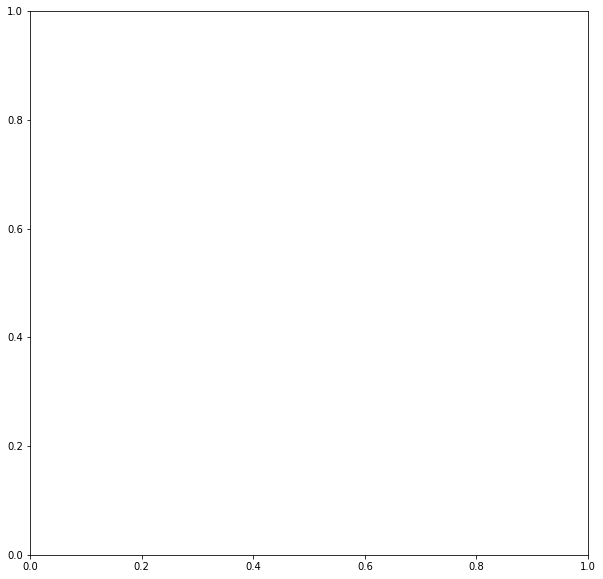

In [122]:
plot_path(path_GD,f,'Steepest descent', skip=100)

Recall that we can approximate the convergence rate based on the error in each iteration (See discussion 4),

$$ p\approx \frac{\ln(e_{k+1}/e_k)}{\ln(e_k/e_{k-1})} $$

Below, we implement a function to do this approximation, given the path:

In [130]:
def approx_convergence_rate(path, minimizer, numToAvg=100, showPlot=False):
    '''Given a path defined by an iteration and a known minimizer, approximates convergence rate'''
    err = np.linalg.norm(path-np.array(minimizer),axis=1) # ||x_k-x*||=e_k
    
    # if converged in very few steps, return infinite order
    if len(err)<=3:
        return np.inf
    
    pp = np.zeros(len(err)-3)
    for i in range(len(err)-3):
        pp[i] = np.log(err[i+2]/err[i+1])/np.log(err[i+1]/err[i])
    
    if numToAvg>len(pp):
        # if not enough iterations to average, just average all
        p=np.mean(pp)
    else:
        # return mean of last few iterations
        p=np.mean(pp[-numToAvg:])
        
    # plot
    if showPlot:
        plt.plot(pp)
        plt.plot(pp*0+p)
        plt.xlabel('k')
        plt.ylabel('p')
        plt.title(f'p={p}')
        plt.show()
        
    return p

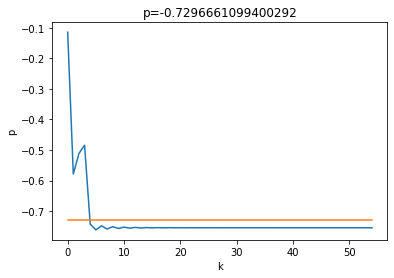

Approximate convergence rate: -0.7296661099400292


In [131]:
print('Approximate convergence rate:',approx_convergence_rate(path_GD,[1,1],showPlot=True))

## Newton's Method

Of course, for small dimensional systems, it is not very expensive to just implement Newton's method directly. For a $2\times2$ system like this, there should be no issue. If the dimensionality of the problem was much larger, the expense of computing the inverse would likely be prohibitive. Even if we could implement an efficient inversion, a major drawback to Newton's method is that the Hessian must now be defined by hand. For the Rosenbrock function,

$$ \nabla^2f(x,y) = \begin{pmatrix} 2-4by+12bx^2 & -4bx \\
                                    -4bx & 2b \end{pmatrix} $$
                                    
which we define as a function before, then implement Newton's method:

In [137]:
%%time
x,y = x0,y0    # initial point
path_Newton = [[x,y]]
tol = 1e-7            # stop when gradient is smaller than this amount
max_steps = 10000     # Maximum number of steps to run the iteration
rho = 0.75            # rho for backtracking
i=0                   # iteration count
dx = Df(x,y)          # current gradient
while np.linalg.norm(dx)>tol and i<max_steps:
    pk = -np.linalg.solve(D2f(x,y),dx)  # faster to solve a system than manually invert

    alpha = 1 # no backtracking necessary, alpha=1 in Newton's method
    
    xnew,ynew = x + alpha*pk[0], y + alpha*pk[1]
    path_Newton.append([xnew,ynew])
    x,y = xnew,ynew
    dx = Df(x,y)
    i += 1

path_Newton=np.array(path_Newton)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 10000 iterations, approximate minimum is 0.0 at (0.0, 0.0)
Wall time: 260 ms


As expected, this converges *much* faster than steepest descent, and we now verify the convergence rate is quadratic (here the method of verifying order isn't precise since we only have 6 iterations).

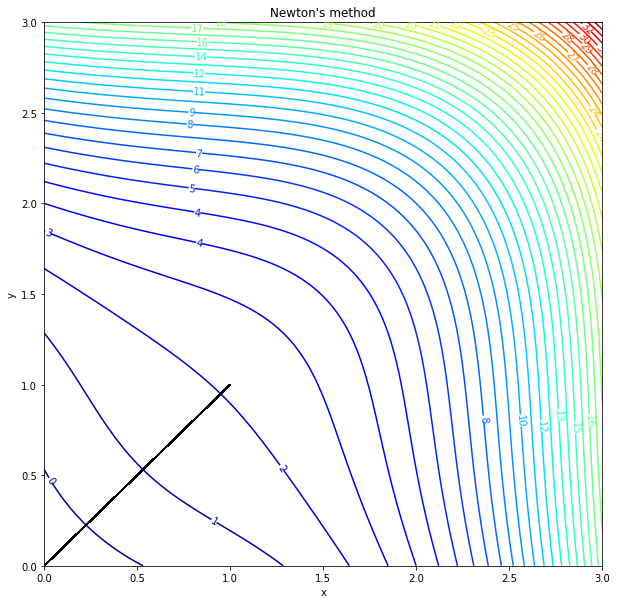

In [143]:
plot_path(path_Newton,f,'Newton\'s method')

In [ ]:
print('Approximate convergence rate:',approx_convergence_rate(path_Newton,[1,1],3,showPlot=True))

## LM Algorithm

In [138]:
def WolfeI(alpha,f,x,dx,p,c1=0.1):
    '''Return True/False if Wolfe condition I is satisfied for the given alpha'''
    LHS = f(x[0]+alpha*p[0], x[1]+alpha*p[1])
    RHS = f(x[0],x[1])+c1*alpha*np.dot(dx,p)
    return LHS <= RHS


In [140]:
%%time
x,y = x0,y0    # initial point
path_LM = [[x,y]]
tol = 1e-7            # stop when gradient is smaller than this amount
max_steps = 10000     # Maximum number of steps to run the iteration
rho = 0.75            # rho for backtracking
i=0                   # iteration count
dx = Df(x,y)          # current gradient
delta = 0.01
while np.linalg.norm(dx)>tol and i<max_steps:
    eigenvalues = np.linalg.eig(D2f(x, y))[0] # Returns eigenvalues of the matrix [lambda_1, lambda_2]
    if min(eigenvalues) > 0:
        mu = 0
    else:
        print(eigenvalues)
        mu = -min(eigenvalues) + delta
    B = D2f(x,y) + mu * np.eye(D2f(x,y).shape[0])
    pk = -np.linalg.solve(B,dx)  # faster to solve a system than manually invert
    
    # backtracking
    alpha = 1
    while not WolfeI(alpha,f,np.array([x,y]),dx,pk) and alpha>1e-5:  # lower limit to prevent small steps, similar to Wolfe II
        alpha *= rho
    xnew,ynew = x + alpha*pk[0], y + alpha*pk[1]
    path_LM.append([xnew,ynew])
    x,y = xnew,ynew
    dx = Df(x,y)
    i += 1

path_LM=np.array(path_LM)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

[-2. -2.]
After 5 iterations, approximate minimum is -8.438272497483172 at (-1.7692923542387216, -1.7692923542387216)
Wall time: 2 ms


In [ ]:
plot_path(path_LM,f,'LM Algorithm')

In [ ]:
print('Approximate convergence rate:',approx_convergence_rate(path_LM,[1,1],showPlot=True))

## Symmetric Rank-1 (SR1) Method

The simplest quasi-Newton method is the **symmetric rank-1 (SR1) method** which requires updates to the inverse Hessian to be of the form

$$ H_{k+1} = H_k + \mathbf{z}_k\mathbf{z}_k^T $$

where $\mathbf{z}_k$ is a vector chosen to satisfy the secant equation, and $H_0$ can be chosen as any positive definite initial approximation (often simply $H_0\equiv I$). The rank one update is then determined by the secant equation to be

$$ \mathbf{z}_k\mathbf{z}_k^T = \frac{(\mathbf{s}_k - H_k \mathbf{y}_k) (\mathbf{s}_k - H_k \mathbf{y}_k)^T}{(\mathbf{s}_k - H_k \mathbf{y}_k)^T \mathbf{y}_k} $$

We mentioned a few drawbacks of SR1, including that the denominator of this update can possibly vanish, and so a check is typically done to skip the update in this case. The SR1 update **does preserve symmetry** of $H_k$, but it **does not preserve positive definiteness** in general, meaning it may not converge in all cases. Despite these drawbacks, when it does converge, SR1 typically does so more quickly than steepest descent but not as quickly as pure Newton. This is verified below:

In [141]:
%%time
x,y = x0,y0    # initial point
path_SR1 = [[x,y]]
tol = 1e-7            # stop when gradient is smaller than this amount
max_steps = 10000     # Maximum number of steps to run the iteration
i=0                   # iteration count
skips = 0             # keep track of how many times SR1 update is skipped
rho = 0.75            # rho for backtracking
H = np.eye(2)         # initial inverse Hessian is identity
dx = Df(x,y)          # current gradient
while np.linalg.norm(dx)>tol and i<max_steps:
    pk = -H@dx
    
    # backtracking
    alpha = 1
    while not WolfeI(alpha,f,np.array([x,y]),dx,pk) and alpha>1e-5:  # lower limit to prevent small steps, similar to Wolfe II
        alpha *= rho
                
    xnew,ynew = x + alpha*pk[0], y + alpha*pk[1]
    path_SR1.append([xnew,ynew])
    
    # secant variables
    sk = alpha*pk         # x_{k+1}-x_k
    yk = Df(xnew,ynew)-dx # Df_{k+1}-Df_k
    
    # SR1 update
    vec = sk-H@yk     # @ is mATrix multiplication
    denom = vec@yk    # computes dot product if two vectors
#     print('Denominator is ',denom)   # uncomment this to do a little inspection
    if abs(denom)>1e-8*np.linalg.norm(vec)*np.linalg.norm(yk):
        # only update if denominator doesn't vanish
        H += np.outer(vec,vec)/denom    # outer product of two vectors works better than a@b.T, which requires reshaping
    else:
        # if denominator vanishes, alert the user
        skips += 1
        if skips<50:
            # set limit so we don't print too much
            print('Skipping SR1 update in iteration',i,'. Denominator is ',denom)
        elif skips==50:
            print('Reached maximum number of skips; breaking loop now.')
            break

    x,y = xnew,ynew
    dx = Df(x,y)
    i += 1

path_SR1=np.array(path_SR1)
print(f'After {i} iterations, approximate minimum is {f(x,y)} at {x,y}')

After 7 iterations, approximate minimum is -8.438272497483172 at (-1.769292354267203, -1.769292354267203)
Wall time: 993 µs


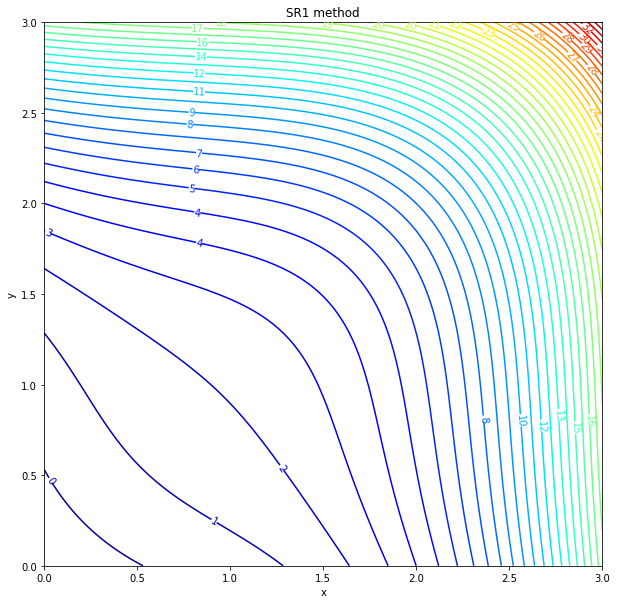

Approximate convergence rate: -0.08561210639022811


In [142]:
plot_path(path_SR1,f,'SR1 method')
print('Approximate convergence rate:',approx_convergence_rate(path_SR1,[1,1],4))

## In summary

### Newton's Method:

$$ \mathbf{x}_{k+1} = \mathbf{x}_k - \left[\nabla^2 f_k\right]^{-1}\nabla f_k $$

#### Convergence
* Quadratic convergence if $\nabla^2 f$ is invertible and your starting point is close to the minimizer.
* Global convergence if $\nabla^2 f > 0$ (and you use Newton's Method + Line Search to determine $\alpha$) - if you don't use Line search you can still have a step size that's too large
* Converges in 1 step for quadratic functions $(f(x) = \frac{1}{2} x^T Q x - b^T x)$

#### Advantages
* Quadratic convergence when starting close enough to the minimizer - faster than Quasi-Newton when it works

#### Disadvantages

* Have to calculate $\nabla^2 f$ and $\nabla f$ by hand.
* Have to invert $\nabla^2 f$ (computationally costly)
* Only local convergence is guaranteed
* Not guaranteed to be descent direction

### LM Algorithm

Newton's method but force $\nabla f$ to be positive definite: It's a mixture of Newton's Method and Steepest Descent.

$$B_k=\nabla^2 f_k + \mu_k I$$
$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_kB_k^{-1}\nabla f_k$$

#### Advantages
* Global convergence

####  Disadvantages
* Have to calculate $\nabla^2 f$ and $\nabla f$ by hand.
* Have to invert $\nabla^2 f$ (computationally costly)
* Have to compute eigenvalues of $\nabla^2 f$ (computationally costly)
* Sometimes only linear convergence

### SR-1 Method
\begin{align*}
\mathbf{x}_{k+1} &= \mathbf{x}_k - \alpha_kH_k\nabla f_k\\
H_{k+1} &= H_k + \mathbf{z}_k\mathbf{z}_k^T\\
\mathbf{z}_k\mathbf{z}_k^T &= \frac{(\mathbf{s}_k - H_k \mathbf{y}_k) (\mathbf{s}_k - H_k \mathbf{y}_k)^T}{(\mathbf{s}_k - H_k \mathbf{y}_k)^T \mathbf{y}_k}
\end{align*}

#### Convergence
* Superlinear convergence with $1 < p < 2$; faster than Steepest Descent, slower than Newton's Method
* When used with exact line search, converges in n steps for quadratic functions $(f(x) = \frac{1}{2} x^T Q x - b^T x)$, where $n$ is the dimension of the vector.

#### Advantages
* No need to calculate or invert $\nabla^2 f$; much less computational cost

#### Disadvantages
* Can fail if denominator is approximately zero.
* Not guaranteed to be descent direction